In [1]:
import sys
sys.path.append("..")
import xrft
import cmocean
import math
import xarray as xr
import numpy as np
from LESutils import load_stats, load_full, UASprofile, load_timeseries, ec_tow,\
read_f90_bin, calc_increments, read_checkpoint_binary, interp_checkpoint_2d
from spec import spectrogram, autocorr_2d
from scipy.stats import gmean
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift
from scipy.signal import fftconvolve, detrend
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from matplotlib import pyplot as plt

# Test reading checkpoint file and 2d interpolation

In [ ]:
fcheck = "/home/bgreene/simulations/SBL_JFM/cr0.25_128/output/checkpoint_0540000.out"
fdir_save = "/home/bgreene/simulations/SBL_JFM/cr0.25_128/"
nx, ny, nz = 128, 128, 128
nf = 4
interp_checkpoint_2d(fcheck, fdir_save, nx, ny, nz, nf)

In [ ]:
t1 = c[4] * 300

t2 = read_f90_bin("/home/bgreene/simulations/SBL_JFM/cr0.25_128/output/theta_0540000.out", 128, 128, nz, 8) * 300

In [ ]:
Lx1, Ly1 = np.linspace(0, 800, 512), np.linspace(0, 800, 512)
Lx2, Ly2 = np.linspace(0, 800, 128), np.linspace(0, 800, 128)

# lvl = np.linspace(1, 8, 21)
lvl=21
jz = 10

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
cax = ax[0].contourf(Lx1, Ly1, t1[:,:,jz].T, levels=lvl)
ax[1].contourf(Lx2, Ly2, t2[:,:,jz].T, levels=lvl)
fig.colorbar(cax, ax=ax)

In [ ]:
z = np.linspace(0, 400, 128)
plt.plot(t1.mean(axis=(0,1)), z)
plt.plot(t2.mean(axis=(0,1)), z)

In [13]:
f = "/home/bgreene/simulations/SBL_JFM/cr0.25_384_192/output/u_1440300.out"
d = read_f90_bin(f, 192, 192, 384, 8) * 0.4

Reading file: /home/bgreene/simulations/SBL_JFM/cr0.25_384_192/output/u_1440300.out


Reading file: /home/bgreene/simulations/SBL_JFM/cr0.25_384_192/checkpoint_1440000_interp.out


Reshaping arrays
Finished reading and reshaping! Returning...
Reading file: /home/bgreene/simulations/SBL_JFM/cr0.25_384/checkpoint_1441000_interp.out
Reshaping arrays
Finished reading and reshaping! Returning...
Reading file: /home/bgreene/simulations/SBL_JFM/cr0.25_384_192/output/u_1441000.out


Text(0, 0.5, '$E_{uu}$ [m2/s2]')

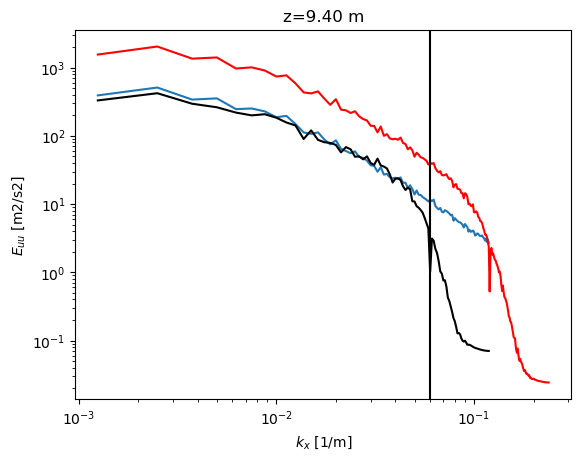

In [17]:
# interpolated start 96x96x384 -> 192x192x384
fcheck = "/home/bgreene/simulations/SBL_JFM/cr0.25_384_192/checkpoint_1440000_interp.out"
nx, ny, nz = 192, 192, 384
c = read_checkpoint_binary(fcheck, nx, ny, nz)
uc = c[1] * 0.4
# interpolated start 192x192x384 -> 384^3
fcheck2 = "/home/bgreene/simulations/SBL_JFM/cr0.25_384/checkpoint_1441000_interp.out"
c2 = read_checkpoint_binary(fcheck2, 384, 384, nz)
uc2 = c2[1] * 0.4

dz = 800/384
z = np.linspace(dz/2, 400+dz/2, 384)
jz = 8

# for ts in np.arange(1441000, 1443001, 1000, dtype=np.int32):
ts = 1441000
# 1000 steps 192x192x384
f = f"/home/bgreene/simulations/SBL_JFM/cr0.25_384_192/output/u_{ts:07d}.out"
d = read_f90_bin(f, 192, 192, 384, 8) * 0.4

f_u = np.fft.fft(d[:,:,jz], axis=0)
E_uu = np.abs(f_u * f_u.conj()).mean(axis=1)
kx = np.fft.fftfreq(192, d=800/192)
plt.loglog(kx[1:192//2], E_uu[1:192//2])

f_u = np.fft.fft(uc[:,:,jz], axis=0)
E_uuc = np.abs(f_u * f_u.conj()).mean(axis=1)
kxc = np.fft.fftfreq(192, d=800/192)
plt.loglog(kxc[1:192//2], E_uuc[1:192//2], c="k")

f_u = np.fft.fft(uc2[:,:,jz], axis=0)
E_uuc2 = np.abs(f_u * f_u.conj()).mean(axis=1)
kxc2 = np.fft.fftfreq(384, d=800/384)
plt.loglog(kxc2[1:384//2], E_uuc2[1:384//2], c="r")

# 2000 steps 384^3
# f = f"/home/bgreene/simulations/SBL_JFM/cr0.25_384/output/u_1443000.out"
# d2 = read_f90_bin(f, 384, 384, 384, 8) * 0.4
# f_u = np.fft.fft(d2[:,:,jz], axis=0)
# E_uu2 = np.abs(f_u * f_u.conj()).mean(axis=1)
# kx2 = np.fft.fftfreq(384, d=800/384)
# plt.loglog(kx2[1:384//2], E_uu2[1:384//2], c="g")

xx = np.array([1e-2, 1e-1])
yy = 0.1*xx**(-5/3)
# plt.loglog(xx, yy, c="k")
plt.title(f"z={z[jz]:.2f} m")

plt.axvline(96/800/2, c="k")
plt.xlabel("$k_x$ [1/m]")
plt.ylabel("$E_{uu}$ [m2/s2]")

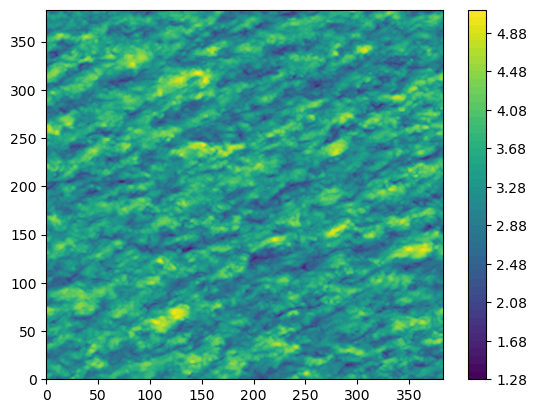

In [16]:
plt.contourf(uc2[:,:,16].T, levels=51)
plt.colorbar()

In [23]:
f = "/home/bgreene/simulations/SBL_JFM/cr0.25_384/output/u_1000000.out"
u = read_f90_bin(f, 96, 96, 384, 8) * 0.4
# u = u[:,:,8]

x = np.linspace(0, 800, 96)
y = np.linspace(0, 800, 96)

xx, yy = np.meshgrid(x, y, indexing="ij", sparse=True)

interp = RegularGridInterpolator(points=((x,y)), values=u, method="cubic", fill_value=None)

xnew = np.linspace(0, 800, 192)
ynew = np.linspace(0, 800, 192)
XX, YY = np.meshgrid(xnew, ynew, indexing="ij")

unew = interp((XX,YY))

Reading file: /home/bgreene/simulations/SBL_JFM/cr0.25_384/output/u_1000000.out


In [18]:
unew.shape

(192, 192)

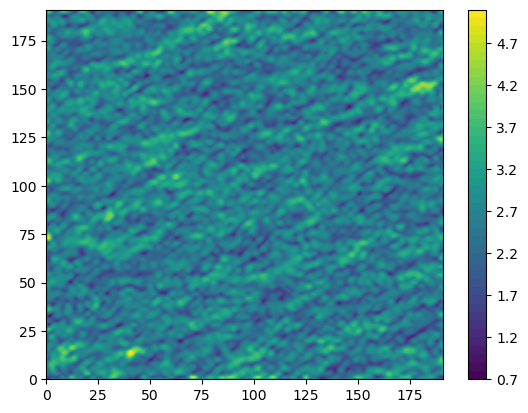

In [21]:
plt.contourf(unew.T, levels=51)
plt.colorbar()

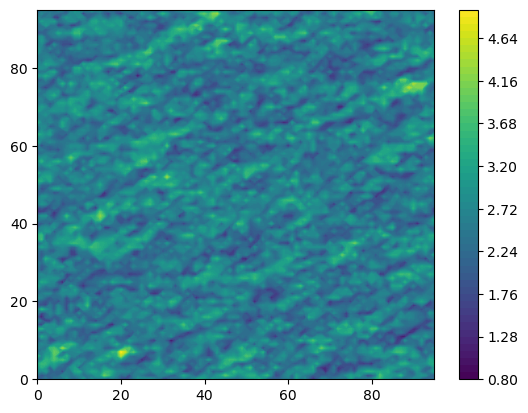

In [32]:
plt.contourf(u[:,:,8].T, levels=51)
plt.colorbar()

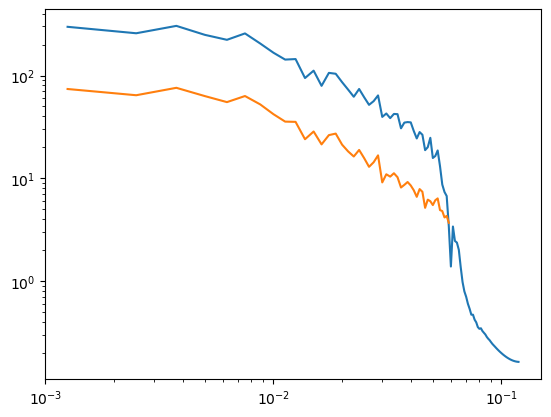

In [22]:
f_u = np.fft.fft(unew, axis=0)
E_uu = np.abs(f_u * f_u.conj()).mean(axis=1)
kx = np.fft.fftfreq(192, d=800/192)

plt.loglog(kx[1:192//2], E_uu[1:192//2])

f_u2 = np.fft.fft(u, axis=0)
E_uu2 = np.abs(f_u2 * f_u2.conj()).mean(axis=1)
kx2 = np.fft.fftfreq(96, d=800/96)

plt.loglog(kx2[1:96//2], E_uu2[1:96//2])

# Compute derivatives in x/y in spectral space

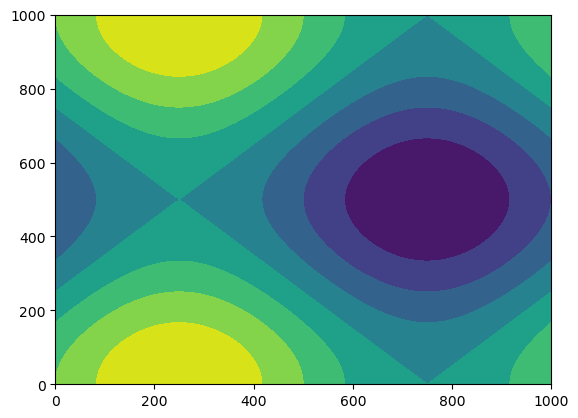

In [83]:
x = np.linspace(0, 1000, 128)
y = np.linspace(0, 1000, 128)

xx, yy = np.meshgrid(x, y)

z = np.sin(2*np.pi*xx/1000) + np.cos(2*np.pi*yy/1000)

plt.contourf(xx, yy, z)

/home/bgreene/anaconda3/envs/LES/lib/python3.10/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


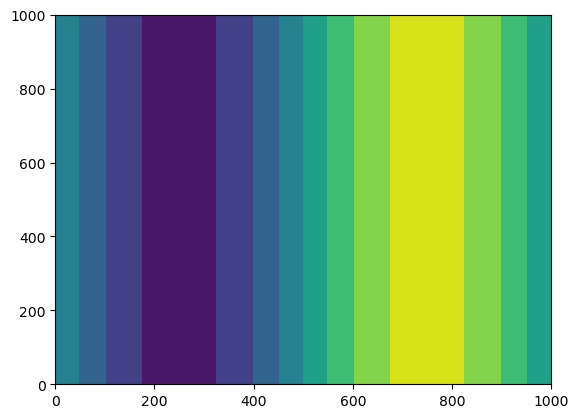

In [96]:
f_z_x = np.fft.fft(z, axis=0)
kx = np.fft.fftfreq(128, d=1000/128)

f_z_x_ik = 1j * kx * f_z_x.T

dz_dx = np.fft.ifft(f_z_x_ik.T, axis=0)

plt.contourf(xx, yy, dz_dx.T)

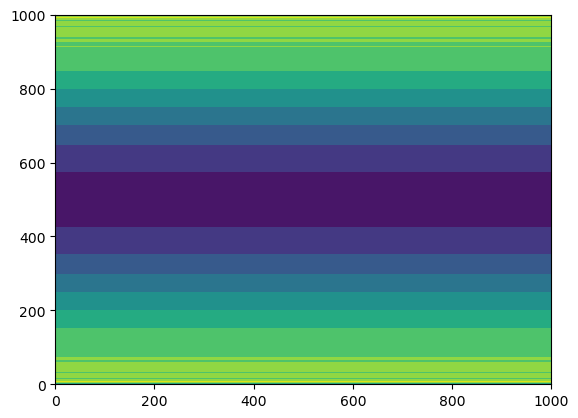

In [93]:
f_z_y = np.fft.fft(z, axis=1)
ky = np.fft.fftfreq(128, d=1000/128)

f_z_y_ik = 1j * ky * f_z_y

dz_dy = np.fft.ifft(f_z_y_ik, axis=1)

plt.contourf(xx, yy, dz_dy.T)

In [ ]:
def d_dx(a, Lx, nx):
    # compute x-derivative of a 3d variable a using fft
    # d_dx = ifft[i*kx*fft(a, axis=0)]

    # take the fft of a long x-dimension
    f_a = np.fft.fft(a, axis=0)
    # construct wavenumbers in x
    kx = np.fft.fftfreq(nx, d=Lx/nx)
    # multiply i * kx * f_a *along x-axis/axis=0*
    

# Load data

In [ ]:
# q_test_3
dnc = "/home/bgreene/simulations/CBL/u15_tw03_qw01_dq-08/"
# t0 = 480000
t0 = 540000
t1 = 540000
dt = 1000
delta_t = 0.04

d, s = load_full(dnc, t0, t1, dt, delta_t, "mean_stats_xyt_5-6h.nc", False)
d2,_ = load_full(dnc, t0, t1, dt, delta_t, "mean_stats_xyt_5-6h.nc", True)

# Test 2d to polar autocorrelation

In [ ]:
# compute spectra with rotated data only in x', average in y'
u2 = d2.u_rot.isel(time=0)
# compute 1d PSD for u_rot
PSD2 = xrft.power_spectrum(u2, dim=("x"), detrend_type="constant", 
                           true_phase=True, true_amplitude=True)
E2 = PSD2.mean(dim=("y"))
E2 = E2.where(E2.freq_x > 0., drop=True).compute()

In [ ]:
# compute 2d PSD for u_rot
u = d.u.isel(time=0)
PSD = xrft.power_spectrum(u, dim=("x","y"), detrend_type="constant", 
                          true_phase=True, true_amplitude=True)
# convert to numpy
PSDn = PSD.to_numpy()
# grab wavenumbers
kx, ky = np.meshgrid(PSD.freq_x, PSD.freq_y, indexing="ij")
kh = np.sqrt(kx**2 + ky**2).flatten()
# sort wavenumbers and keep indices
jkh = np.argsort(kh)
kh_sort = kh[jkh]
# define variables
nk = 128
kh_bin = E2.freq_x.to_numpy()
# kh_bin = np.linspace(kh_sort[1], kh.max(), nk)
nk = len(kh_bin)
nz = u.shape[-1]
dk = np.diff(kh_bin)[0]
E_bin = np.zeros((nk, nz), np.float64)
njk = []
# loop over all z
for jz in range(nz):
    E = PSDn[:,:,jz].flatten()
    E_sort = E[jkh]
    # average over wavenumber bins
    for jk in range(nk):
        jk_bin = np.where((kh_sort >= kh_bin[jk]-dk/2.) &\
                          (kh_sort < kh_bin[jk]+dk/2.))[0]
        E_bin[jk,jz] = gmean(E_sort[jk_bin])
        if jz == 0:
            njk.append(len(jk_bin))

In [ ]:
plt.loglog(1/kh_bin/s.h.values, njk)

In [ ]:
jz = 13
plt.loglog(kh_bin, E_bin[:,jz], "x")
KX = np.array([1e-4, 1e-2])
Y = KX ** (-5/3)
plt.loglog(KX, Y)
plt.ylim([1e-1, 1e7])
plt.loglog(E2.freq_x, E2[:,jz], ".")

In [ ]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5), constrained_layout=True)
E_bin_scaled = np.zeros_like(E_bin)
for jz in range(nz):
    E_bin_scaled[:,jz] = kh_bin * E_bin[:,jz]

cax0 = ax[0].contour(E2.z/s.h, 1/kh_bin/s.h.values, E_bin_scaled,
                     levels=np.linspace(0, 75, 21), extend="max")
cax1 = ax[1].contour(E2.z/s.h, 1/E2.freq_x/s.h, E2.freq_x*E2,
                     levels=np.linspace(0, 0.8, 21), extend="max")

fig.colorbar(cax0, ax=ax[0], location="top")
fig.colorbar(cax1, ax=ax[1], location="top")

ax[0].set_xscale("log")
ax[0].set_yscale("log")

In [ ]:
(E2.freq_x*E2).max().values, E_bin_scaled.max()

# Test spectrogram function

In [ ]:
spectrogram(dnc, df)

In [ ]:
# load file
E = xr.load_dataset(dnc+"spectrogram.nc")
Eu = E.uu.where(E.freq_x > 0, drop=True).compute()
Etw = E.tw.where(E.freq_x > 0, drop=True).compute()
Ew = E.ww.where(E.freq_x > 0, drop=True).compute()

In [ ]:
(Eu.freq_x*Eu/s.wstar/s.wstar).real.max()

In [ ]:
plt.contour(Eu.z/s.h,
            1/Eu.freq_x/s.h, 
            Eu.freq_x*Eu.real/s.wstar/s.wstar,
            levels=21, extend="both")
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlim([0.005, 1])
plt.ylim([0.1, 10])
plt.xlabel("$z/z_i$")
plt.ylabel("$\\lambda_x/z_i$")

In [ ]:
plt.contour(Etw.z/s.h,
            1/Etw.freq_x/s.h, 
            Etw.freq_x*Etw.real/s.wstar/s.Tstar0,
            levels=21, extend="both")
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlim([0.005, 1])
plt.ylim([0.1, 10])
plt.xlabel("$z/z_i$")
plt.ylabel("$\\lambda_x/z_i$")

In [ ]:
# just plot 1d spectrum at z/zi = 0.1
Eu = E.uu.where(E.freq_x > 0, drop=True).compute()

In [ ]:
for zz in [0.05, 0.1, 0.25, 0.5]:
    jz = abs((E.z/s.h).values - zz).argmin()
    plt.plot(Eu.freq_x*s.h, Eu.freq_x*Eu.isel(z=jz)/s.wstar/s.wstar)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k_x z_i$")
plt.ylabel("$k_x \\phi_{uu} w_{*}^{-2}$")

# Detrend in time and calc stats, compare with no detrend

In [ ]:
# detrend with local means with quick notation using xarray
td1 = df.theta - df.theta.mean(dim=("x","y"))
wd1 = df.w - df.w.mean(dim=("x","y"))
twd1 = (td1 * wd1).mean(dim=("x","y","time")).compute()
ttd1 = (td1 * td1).mean(dim=("x","y","time")).compute()

In [ ]:
# detrend using scipy function
td2 = detrend(df.theta, axis=0, type="linear")
wd2 = detrend(df.w, axis=0, type="linear")
twd2 = np.mean(td2 * wd2, axis=(0,1,2))
ttd2 = np.mean(td2 * td2, axis=(0,1,2))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(14.8, 5))

cfax0 = ax[0].contourf(df.x, df.y, td1.isel(time=72, z=0).T, levels=np.linspace(-4,4,25), cmap=cmocean.cm.balance)
cfax1 = ax[1].contourf(df.x, df.y, td2[72,:,:,0].T, levels=np.linspace(-4,4,25), cmap=cmocean.cm.balance)

cb01 = fig.colorbar(cfax1, ax=ax)

In [ ]:
# plot detrended twd versus stats
q3_mean = s.tw_cov_tot - s.tw_cov_res
plt.plot(s.tw_cov_tot, s.z)
plt.plot(twd1 + q3_mean, s.z)
plt.plot(twd2 + q3_mean, s.z)
# plt.plot(twd3 + q3_mean, s.z)

In [ ]:
plt.plot(s.theta_var, s.z)
plt.plot(ttd1, s.z)
plt.plot(ttd2, s.z)
# plt.plot(ttd3, s.z)

In [ ]:
# plot theta'
plt.plot(df.time, df.theta.isel(x=96, y=96, z=10)-s.theta_mean[10])
plt.plot(df.time, td1.isel(x=96, y=96, z=10))
plt.plot(df.time, td2[:,96,96,10])
# plt.plot(df.time, td3[:,96,96,10])

In [ ]:
# plot w'
plt.plot(df.time, df.w.isel(x=96, y=96, z=10)-s.w_mean[10], label="stat", lw=5)
plt.plot(df.time, wd1.isel(x=96, y=96, z=10), label="wd1")
plt.plot(df.time, wd2[:,96,96,10], label="wd2")
# plt.plot(df.time, wd3[:,96,96,10])
plt.legend()

In [ ]:
plt.plot(df.time, df.q3.isel(z=10).mean(dim=("x","y")))

In [ ]:
# use old code logic to compare fluxes
tw = np.zeros((128), dtype=np.float64)
count = 0

for jt in range(288000, 432000, 1000):
    t_in = read_f90_bin(f"/home/bgreene/simulations/q_test_3/output/theta_{jt:07d}.out", 128,128,128,8) * 300
    w_in = read_f90_bin(f"/home/bgreene/simulations/q_test_3/output/w_{jt:07d}.out", 128,128,128,8) * 0.4
    q3_in = read_f90_bin(f"/home/bgreene/simulations/q_test_3/output/q3_{jt:07d}.out", 128,128,128,8) * 0.4 * 300

    tp, wp = [np.zeros((128, 128, 128), dtype=np.float64) for _ in range(2)]
    for jz in range(128):
        tp[:,:,jz] = t_in[:,:,jz] - np.mean(t_in[:,:,jz])
        wp[:,:,jz] = w_in[:,:,jz] - np.mean(w_in[:,:,jz])

    for jz in range(128):
        tw[jz] += np.mean(tp[:,:,jz] * wp[:,:,jz]) + np.mean(q3_in[:,:,jz])

    count += 1

tw /= count

In [ ]:
plt.plot(tw, np.linspace(0, 2000, 128))
plt.plot(s.tw_cov_tot, s.z)

# look at some of Scotts sims

In [ ]:
tw = np.zeros((160), dtype=np.float64)
count = 0

for jt in range(288000, 360000, 1000):
    t_in = read_f90_bin(f"/share/yeti/simulations/cbl/u15_q07_160/output/theta_{jt:07d}.out", 160,160,160,8) * 300
    w_in = read_f90_bin(f"/share/yeti/simulations/cbl/u15_q07_160/output/w_{jt:07d}.out", 160,160,160,8) * 0.4
    q3_in = read_f90_bin(f"/share/yeti/simulations/cbl/u15_q07_160/output/q3_{jt:07d}.out", 160,160,160,8) * 0.4 * 300

    tp, wp = [np.zeros((160, 160, 160), dtype=np.float64) for _ in range(2)]
    for jz in range(160):
        tp[:,:,jz] = t_in[:,:,jz] - np.mean(t_in[:,:,jz])
        wp[:,:,jz] = w_in[:,:,jz] - np.mean(w_in[:,:,jz])

    for jz in range(160):
        tw[jz] += np.mean(tp[:,:,jz] * wp[:,:,jz]) + np.mean(q3_in[:,:,jz])

    count += 1

tw /= count

In [ ]:
plt.plot(tw/tw[0], np.linspace(0, 2000, 160))

# Calculate acf with code from RFMnc.py

In [ ]:
u = df.u

temp = (u - u.mean(dim=("x"))) / u.std(dim=("x"))
corr_xx = fftconvolve(temp, temp[:,::-1,:,:]/u.x.size, mode="full", axes=1)
corr_xx_ytavg = np.mean(corr_xx, axis=(0,2))
imid = (2*u.x.size-1)//2
R1 = xr.DataArray(data=corr_xx_ytavg[imid:,:], dims=["x","z"], coords=dict(x=u.x, z=u.z))

# Calculate acf with code from LESnc.py

In [ ]:
u = df.u

R = np.zeros((df.nx, df.nz), dtype=np.float64)

for jt in range(df.time.size):
    PSD = np.zeros((df.nx, df.ny, df.nz), dtype=np.float64)
    d = u.isel(time=jt).to_numpy()
    f = fft(d, axis=0)
    for jx in range(1, df.nx//2):
        PSD[jx,:,:] = np.real( f[jx,:,:] * np.conj(f[jx,:,:]) )
        PSD[df.nx-jx,:,:] = np.real( f[df.nx-jx,:,:] * np.conj(f[df.nx-jx,:,:]) )
    PSD /= np.var(d, axis=0)
    r = np.real( ifft(PSD, axis=0) ) / df.nx
    R += np.mean(r, axis=1)
R /= df.time.size

R2 = xr.DataArray(data=R, dims=["x","z"], coords=dict(x=u.x, z=u.z))

In [ ]:
R2.isel(x=0).values

# Calculate acf with np.abs()

In [ ]:
u = df.u

R = np.zeros((df.nx, df.nz), dtype=np.float64)

for jt in range(df.time.size):
    din = u.isel(time=jt).to_numpy()
    d = (din - din.mean(axis=0)) / din.std(axis=0)
    f = fft(d, axis=0)
    PSD = np.abs(f) ** 2.
    r = np.real( ifft(PSD, axis=0) ) / df.nx
    R += np.mean(r, axis=1)
R /= df.time.size
R3 = xr.DataArray(data=R, dims=["x","z"], coords=dict(x=u.x, z=u.z))

# Use function from spec.py

In [ ]:
from spec import autocorr_1d

autocorr_1d("/home/bgreene/", df)
R1d = xr.load_dataset("/home/bgreene/R_1d.nc")

# Use xrft package

In [ ]:
u = df.u

# up = (u - u.mean(dim="x")) / u.std(dim="x")
ud = xrft.detrend(u, dim="x", detrend_type="constant")
up = ud / ud.std(dim="x")
PSD = xrft.power_spectrum(up, dim="x", true_phase=True, true_amplitude=True)
r = xrft.ifft(PSD, dim="freq_x", true_phase=True, true_amplitude=True, lag=0).real
Rxu = r.mean(dim=("y","time"))

In [ ]:
v = df.v

# up = (u - u.mean(dim="x")) / u.std(dim="x")
vd = xrft.detrend(v, dim="x", detrend_type="constant")
vp = vd / vd.std(dim="x")
PSD = xrft.power_spectrum(vp, dim="x", true_phase=True, true_amplitude=True)
r = xrft.ifft(PSD, dim="freq_x", true_phase=True, true_amplitude=True, lag=0).real
Rxv = r.mean(dim=("y","time"))

In [ ]:
Rsave = xr.Dataset(data_vars=None, attrs=df.attrs)

Rsave["u"] = Rxu
Rsave["v"] = Rxv

Rsave

# Plot both

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))

# ax.plot(R1.x[:df.nx//2], R1.isel(z=5, x=range(df.nx//2)), c="k", lw=2, label="fftconvolve")
# ax.plot(R2.x[:df.nx//2], R2.isel(z=5, x=range(df.nx//2)), c="r", lw=2, label="PSD")
ax.plot(R3.x[:df.nx//2], R3.isel(z=5, x=range(df.nx//2)), c="b", lw=2, label="ABS")
ax.plot(R1d.x[R1d.x.size//2:], R1d.u.isel(z=5, x=range(R1d.x.size//2, R1d.x.size)), c="r", label="xrft")
# ax.plot(R1d.x, R1d.u.isel(z=5), c="k", lw=2, ls="--", label="autocorr1d")
ax.legend()
ax.axhline(0, c="k", ls="--")

# Compute 2d acf

In [ ]:
u = df.u

R = np.zeros((df.nx, df.ny, df.nz), dtype=np.float64)

for jt in range(df.time.size):
    # PSD = np.zeros((df.nx, df.ny, df.nz), dtype=np.float64)
    din = u.isel(time=jt).to_numpy()
    d = (din - np.mean(din, axis=(0,1))) / np.std(din, axis=(0,1))
    f = fft2(d, axes=(0,1))
    PSD = np.abs(f) ** 2.
    # for jx in range(1, df.nx//2):
    #     for jy in range(1, df.ny//2):
    #         # kx > 0, ky > 0
    #         PSD[jx,jy,:] = np.real( f[jx,jy,:] * np.conj(f[jx,jy,:]) )
    #         # kx < 0, ky > 0
    #         PSD[df.nx-jx,jy,:] = np.real( f[df.nx-jx,jy,:] * np.conj(f[df.nx-jx,jy,:]) )
    #         # kx > 0, ky < 0
    #         PSD[jx,df.ny-jy,:] = np.real( f[jx,df.ny-jy,:] * np.conj(f[jx,df.ny-jy,:]) )
    #         # kx < 0, ky < 0
    #         PSD[df.nx-jx,df.ny-jy,:] = np.real( f[df.nx-jx,df.ny-jy,:] * np.conj(f[df.nx-jx,df.ny-jy,:]) )
    # PSD /= np.var(d, axis=(0,1))
    # for jz in range(df.nz):
    #     for jx in range(df.nx):
    #         PSD[jx,:,jz] /= np.std(d[jx,:,jz])
    #     for jy in range(df.ny):
    #         PSD[:,jy,jz] /= np.std(d[:,jy,jz])
    r = np.real( ifft2(PSD, axes=(0,1)) ) / df.nx / df.ny
    R += r
R /= df.time.size

R3 = xr.DataArray(data=R, dims=["x", "y", "z"], coords=dict(x=u.x, y=u.y, z=u.z))

# 2d acf with xrft

In [ ]:
u = df.u

ufluc = xrft.detrend(u, dim=("x","y"), detrend_type="constant")
unorm = ufluc / ufluc.std(dim=("x","y"))
PSD = xrft.power_spectrum(unorm, dim=("x","y"), true_phase=True, true_amplitude=True)
R = xrft.ifft(PSD, dim=("freq_x","freq_y"), true_phase=True, true_amplitude=True, lag=(0,0)).real
R_tavg = R.mean(dim=("time"))

# 2d acf using spec.py

In [ ]:
from spec import autocorr_2d

autocorr_2d("/home/bgreene/", df)
R2d = xr.load_dataset("/home/bgreene/R_2d.nc")

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))

ax.plot(R3.x[:df.nx//2], R3.isel(z=5, x=range(df.nx//2), y=0), c="b", lw=2, label="ABS")
ax.plot(R2d.x[R2d.x.size//2:], 
        R2d.u.isel(z=5, y=R2d.y.size//2, x=range(R2d.x.size//2, R2d.x.size)), 
        c="k", lw=2, ls="--", label="autocorr2d")
ax.plot(R_tavg.x[R_tavg.x.size//2:], 
        R_tavg.isel(z=5, y=R_tavg.y.size//2, x=range(R_tavg.x.size//2, R_tavg.x.size)), 
        c="r", label="xrft")
ax.legend()
ax.axhline(0, c="k", ls="--")

In [ ]:
import cmocean
jz = abs((R_tavg.z/s.h).values - 0.1).argmin()
fig, ax = plt.subplots(1)
cfax=ax.contourf(R_tavg.x/s.h, R_tavg.y/s.h, R_tavg.isel(z=jz).T, levels=np.linspace(-1, 1, 21), cmap=cmocean.cm.balance)
fig.colorbar(cfax, ax=ax)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

In [ ]:
PSD[1,1,:]

In [ ]:
R3.isel(x=50, y=0, z=range(s.nzabl)).values

In [ ]:
np.mgrid[:5, :5][0]

In [ ]:
n = 160
a = np.random.rand(n,n)
aa = (a - a.mean()) / a.std()

f = fft2(aa)
# PSD = np.zeros((n, n), dtype=np.float64)
# for jx in range(1, n//2):
#     for jy in range(1, n//2):
#         PSD[jx,jy] = np.real(f[jx,jy]*np.conj(f[jx,jy]))
#         PSD[n-jx,jy] = np.real(f[n-jx,jy]*np.conj(f[n-jx,jy]))
#         PSD[jx,n-jy] = np.real(f[jx,n-jy]*np.conj(f[jx,n-jy]))
#         PSD[n-jx,n-jy] = np.real(f[n-jx,n-jy]*np.conj(f[n-jx,n-jy]))
PSD = np.abs(f)**2. #/ np.var(a)
# PSD /= np.var(a)
R = np.real( ifft2(PSD) ) / n / n
R

In [ ]:
n = 192
a = np.random.rand(n)
f = fft(a)
PSD = np.zeros(n, dtype=np.float64)
for jx in range(1, n//2):
    PSD[jx] = np.real(f[jx] * np.conj(f[jx]))
    PSD[n-jx] = np.real(f[n-jx] * np.conj(f[n-jx]))
PSD /= np.var(a)
R = np.real(ifft(PSD))/n
R[0]

# Evaluate UAS profiles

In [ ]:
# CBL case u15_q10_160
dnc = "/home/lotterstatter/simulations/cbl/u09_q24_160/output/netcdf/"
ts = load_timeseries(dnc, detrend=False, tavg="1.0h")

err = xr.load_dataset(dnc+"err.nc")

In [ ]:
UAS = UASprofile(ts, zmax=1200, err=err, time_average=3)

In [ ]:
plt.plot(UAS.wspd, UAS.z, lw=1, c="k")
plt.fill_betweenx(UAS.z, UAS.wspd-UAS.wspd_err, UAS.wspd+UAS.wspd_err, color="k", alpha=0.4)
plt.fill_betweenx(UAS.z, UAS.wspd-3*UAS.wspd_err, UAS.wspd+3*UAS.wspd_err, color="k", alpha=0.25)

plt.xlabel("$U_h$ [m/s]")
plt.ylabel("Altitude [m]")

In [ ]:
UAS.z

# Evaluate EC Tower profiles

In [ ]:
ec = ec_tow(ts, h=1500, time_average=[1800, 3600])

In [ ]:
ec

In [ ]:
plt.plot(ec.w_var.isel(Tsample_ec=0), ec.z, label=ec.Tsample_ec[0].values)
plt.plot(ec.w_var.isel(Tsample_ec=1), ec.z, label=ec.Tsample_ec[1].values)
plt.legend()

# Misc. math

In [ ]:
x = np.linspace(-1000, 1000, 101)
y = np.linspace(-1000, 1000, 101)

xx, yy = np.meshgrid(x, y)

r = (xx**2. + yy**2.) ** (0.5)
theta = np.arctan2(yy, xx)
thetad = theta * 180./np.pi

In [ ]:
xx[0,0], yy[0,0]

In [ ]:
thetad[0,0]

In [ ]:
plt.contourf(xx, yy, r)
plt.colorbar()

In [ ]:
import cmocean
plt.contourf(xx, yy, theta, levels=25, cmap=cmocean.cm.phase)
plt.colorbar()

In [ ]:
plt.contourf(thetad, r, xx, cmap=cmocean.cm.balance)
# plt.plot(thetad, r, "xk")
plt.colorbar()
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$")

In [ ]:
plt.plot(theta, r, "xb")

In [ ]:
# load autocorr data and select slice for testing
dd = xr.load_dataset("/home/bgreene/R_2d.nc")
u = dd.u.isel(z=3)

# calculate 2d arrays of theta=theta(x,y), r=r(x,y)
theta = np.arctan2(u.y, u.x)
r = (u.x**2. + u.y**2.) ** 0.5
# grab sizes of x and y dimensions for looping
nx, ny = u.x.size, u.y.size
# set up bin centers for averaging
ntbin = 11
nrbin = 10
rbin = np.linspace(0, 300, nrbin)
tbin = np.linspace(-np.pi, np.pi, ntbin)
# intiialize empty arrays for storing values and counter for normalizing
uall, count = [np.zeros((ntbin, nrbin), dtype=np.float64) for _ in range(2)]
# loop over x, y pairs
for jx in range(nx):
    for jy in range(ny):
        # find nearest bin center for each r(jx,jy) and theta(jx,jy)
        jr = abs(rbin - r.isel(x=jx,y=jy).values).argmin()
        jt = abs(tbin - theta.isel(x=jx,y=jy).values).argmin()
        # store u[jt,jr] in uall, increment count
        uall[jt,jr] += u[jx,jy]
        count[jt,jr] += 1

# normalize uall by count
umean = uall / count

In [ ]:
Rmax_r = np.nanmax(umean, axis=0) - np.nanmin(umean, axis=0)
rbin_zi = rbin / 200
RR = np.max(Rmax_r[rbin_zi >= 0.5])
RR

In [ ]:
plt.contourf(tbin, rbin, umean.T, levels=np.linspace(0, 0.8, 25), extend="both")
plt.colorbar()
plt.xlabel("$\\theta$")
plt.ylabel("$\\rho$")

In [ ]:
plt.contourf(theta, r, u)
plt.colorbar()

In [ ]:
plt.contourf(u.x, u.y, u.T, levels=np.linspace(0, 1, 25), extend="min")
plt.colorbar()
plt.xlim([-100, 100])
plt.ylim([-100, 100])

In [ ]:
u.y.isel(y=u.sel(x=-50, method="nearest").argmax())

In [ ]:
np.arctan2(20.94, 50.26)

In [ ]:
tplot[umean[:,0].argmax()]

# Test coordinate rotation

In [ ]:
Lx, Ly = 12000., 12000.
nx, ny = 128, 128
dx, dy = Lx/nx, Ly/ny
x, y = [np.linspace(0, Lx, nx), np.linspace(0, Ly, ny)]

x_hat, y_hat = [np.zeros((nx,ny), dtype=np.float64) for _ in range(2)]
alpha = 30. * np.pi/180. # convert to radians
ca = np.cos(alpha)
sa = np.sin(alpha)
# loop over old x and y
for jx in range(nx):
    for jy in range(ny):
        x_hat[jx,jy] = math.fmod(jx*dx, Lx)*ca + math.fmod(-jy*dy, Ly)*sa
        y_hat[jx,jy] = math.fmod(jx*dx, Lx)*sa + math.fmod( jy*dy, Ly)*ca

In [ ]:
# fake data: stripe of large values through middle
dat = np.ones((nx,ny), dtype=np.float64)
dat[:,ny//2-5:ny//2+5] = 5
dat[nx//2-5:nx//2+5,:] = 10
dat[-3*nx//4-5:-3*nx//4+5,3*ny//4-5:3*ny//4+5] = 3
dat[-nx//4-5:-nx//4+5,ny//4-5:ny//4+5] = 7
plt.contourf(x, y, dat.T)
plt.colorbar()

In [ ]:
# perform bilinear interpolation
dat_r = np.zeros((nx,ny), dtype=np.float64)
for jx in range(nx):
    for jy in range(ny):
        # indices
        i1 = int(math.fmod(math.floor(x_hat[jx,jy]/dx), nx))
        j1 = int(math.fmod(math.floor(y_hat[jx,jy]/dy), ny))
        i2 = int(math.fmod(i1, nx))
        j2 = int(math.fmod(j1, ny))
        # calculate weights
        x1 = math.fmod(x_hat[jx,jy], dx) / dx
        x2 = math.fmod(y_hat[jx,jy], dy) / dy
        w1 = (1. - x1) * (1. - x2)
        w2 = (   x1  ) * (1. - x2)
        w3 = (1. - x1) * (   x2  )
        w4 = (   x1  ) * (   x2  )
        # interpolate
        dat_r[jx,jy] = dat[i1,j1]*w1 + dat[i2,j1]*w2 + dat[i1,j2]*w3 + dat[i2,j2]*w4

# plot
plt.contourf(x_hat[:,:], y_hat[:,:], dat_r)
plt.colorbar()

In [ ]:
plt.contourf(x, y, dat_r.T)
plt.colorbar()

In [ ]:
# rotate back
alpha2 = -30. * np.pi/180. # convert to radians
ca = np.cos(alpha2)
sa = np.sin(alpha2)
x_hat2, y_hat2 = [np.zeros((nx,ny), dtype=np.float64) for _ in range(2)]
# loop over old x and y
for jx in range(nx):
    for jy in range(ny):
        x_hat2[jx,jy] = math.fmod(jx*dx, Lx)*ca + math.fmod(-jy*dy, Ly)*sa
        y_hat2[jx,jy] = math.fmod(jx*dx, Lx)*sa + math.fmod( jy*dy, Ly)*ca

In [ ]:
# perform bilinear interpolation
dat_r2 = np.zeros((nx,ny), dtype=np.float64)
for jx in range(nx):
    for jy in range(ny):
        # indices
        i1 = int(math.fmod(math.floor(x_hat2[jx,jy]/dx), nx))
        j1 = int(math.fmod(math.floor(y_hat2[jx,jy]/dy), ny))
        i2 = int(math.fmod(i1, nx))
        j2 = int(math.fmod(j1, ny))
        # calculate weights
        x1 = math.fmod(x_hat2[jx,jy], dx) / dx
        x2 = math.fmod(y_hat2[jx,jy], dy) / dy
        w1 = (1. - x1) * (1. - x2)
        w2 = (   x1  ) * (1. - x2)
        w3 = (1. - x1) * (   x2  )
        w4 = (   x1  ) * (   x2  )
        # interpolate
        dat_r2[jx,jy] = dat_r[i1,j1]*w1 + dat_r[i2,j1]*w2 + dat_r[i1,j2]*w3 + dat_r[i2,j2]*w4

# plot
plt.contourf(x_hat2[:,:], y_hat2[:,:], dat_r2)
plt.colorbar()

In [ ]:
plt.contourf(x, y, dat_r2.T)
plt.colorbar()

In [ ]:
alpha = -94 * np.pi/180.

xp = x*np.cos(alpha) - y*np.sin(alpha)
yp = x*np.sin(alpha) + y*np.cos(alpha)

xx, yy = np.meshgrid(x, y)

xxp = xx*np.cos(alpha) - yy*np.sin(alpha)
yyp = xx*np.sin(alpha) + yy*np.cos(alpha)

datbig = np.zeros((4*nx, 4*ny))
for jx in range(4):
    for jy in range(4):
        datbig[jx*nx:(jx+1)*nx,jy*ny:(jy+1)*ny] = dat

# datbig[0:nx,0:ny] = dat
# datbig[nx:2*nx,0:ny] = dat
# datbig[2*nx:,0:ny] = dat
# datbig[0:nx,ny:2*ny] = dat
# datbig[nx:2*nx,ny:2*ny] = dat
# datbig[2*nx:,ny:2*ny] = dat
# datbig[0:nx,2*ny:] = dat
# datbig[nx:2*nx,2*ny:] = dat
# datbig[2*nx:,2*ny:] = dat

xbig = np.linspace(-2*Lx, 2*Lx, 4*nx)
ybig = np.linspace(-2*Ly, 2*Ly, 4*ny)

interp = RegularGridInterpolator((xbig, ybig), datbig)

datinterp = interp(np.array([xxp.ravel(), yyp.ravel()]).T, method="linear").reshape(nx, ny)


plt.contourf(xbig, ybig, datbig)
plt.contourf(xxp, yyp, datinterp.T)
plt.axhline(0, c="r")
plt.axvline(0, c="r")
plt.colorbar()

In [ ]:
# seems to work with test data...use roll case as test
dnc = "/home/bgreene/simulations/u15_tw10_qw04_dry/output/netcdf/"
# t0 = 480000
t0 = 360000
t1 = 432000
dt = 1000
delta_t = 0.05

df, s = load_full(dnc, t0, t1, dt, delta_t, False, "mean_stats_xyt_5-6h.nc")

In [ ]:
x, y, z = df.x, df.y, df.z
Lx, Ly, Lz = df.Lx, df.Ly, df.Lz
nx, ny, nz = df.nx, df.ny, df.nz
dx, dy, dz = df.dx, df.dy, df.dz

jz = abs((s.z/s.h) - 0.10).argmin()
u = df.u.isel(time=-1, z=jz)
v = df.v.isel(time=-1, z=jz)
w = df.w.isel(time=-1, z=jz)

In [ ]:
u_bar = u.mean()
v_bar = v.mean()
alpha = np.arctan2(v_bar, u_bar).values

xp = x*np.cos(alpha) - y*np.sin(alpha)
yp = x*np.sin(alpha) + y*np.cos(alpha)

xx, yy = np.meshgrid(x, y, indexing="xy")

xxp = xx*np.cos(alpha) - yy*np.sin(alpha)
yyp = xx*np.sin(alpha) + yy*np.cos(alpha)

wbig = np.zeros((4*nx, 4*ny))
for jx in range(4):
    for jy in range(4):
        wbig[jx*nx:(jx+1)*nx,jy*ny:(jy+1)*ny] = w

xbig = np.linspace(-2*Lx, 2*Lx, 4*nx)
ybig = np.linspace(-2*Ly, 2*Ly, 4*ny)

interp = RegularGridInterpolator((xbig, ybig), wbig)

winterp = interp(np.array([xxp.ravel(), yyp.ravel()]).T, method="cubic").reshape(nx, ny)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.8, 5))
cax0 = ax[0].contourf(x, y, w.T-w.mean(), levels=np.linspace(-4, 4, 9))
cax1 = ax[1].contourf(x, y, winterp-winterp.mean(), levels=np.linspace(-4, 4, 9))
fig.colorbar(cax1, ax=ax[:])

ax[0].set_xlabel("$x$ [m]")
ax[0].set_ylabel("$y$ [m]")
ax[0].set_title("$w-\\langle w \\rangle_{xy}$")

ax[1].set_xlabel("$x'$ [m]")
ax[1].set_ylabel("$y'$ [m]")
ax[1].set_title("$\\hat{w} - \\langle \\hat{w} \\rangle_{x'y'}$")

fig.suptitle(f"Rotation angle: {alpha*180/np.pi:.0f} deg")

# draw x' and y' axes on lab frame (left panel)
x0 = np.array([6000, 8000])
y0 = np.array([0, 0])

xr0 = x0*np.cos(alpha) - y0*np.sin(alpha)
yr0 = x0*np.sin(alpha) + y0*np.cos(alpha)

x1 = np.array([6000, 6000])
y1 = np.array([0, 2000])

xr1 = x1*np.cos(alpha) - y1*np.sin(alpha)
yr1 = x1*np.sin(alpha) + y1*np.cos(alpha)

ax[0].plot(xr0, yr0, "-r")
ax[0].plot(xr1, yr1, "-r")

ax[0].text(xr0[1]+50, yr0[1]+50, "$x'$", color="r", fontsize=16)
ax[0].text(xr1[1]-50, yr1[1]+50, "$y'$", color="r", fontsize=16)

In [ ]:
# test loop over full 3d grid
# grab data
u = df.u.isel(time=-1).to_numpy()
v = df.v.isel(time=-1).to_numpy()
w = df.w.isel(time=-1).to_numpy()
# calculate angle(z)
u_bar = np.mean(u, axis=(0,1))
v_bar = np.mean(v, axis=(0,1))
angle = np.arctan2(v_bar, u_bar)
# pre-calculate cos and sin of rotation angle
ca = np.cos(angle)
sa = np.sin(angle)
# create big 3d array to fill variable
wbig = np.zeros((4*nx, 4*ny, nz), dtype=np.float64)
for jx in range(4):
    for jy in range(4):
        wbig[jx*nx:(jx+1)*nx,jy*ny:(jy+1)*ny,:] = w
# create lab frame coordinates to match big variable array
xbig = np.linspace(-2*Lx, 2*Lx, 4*nx)
ybig = np.linspace(-2*Ly, 2*Ly, 4*ny)
# create empty array to store interpolated values
winterp = np.zeros((nx, ny, nz), dtype=np.float64)
# create meshgrid of lab coordinates
xx, yy = np.meshgrid(x, y, indexing="xy")
# begin loop over z
for jz in range(nz):
    # calculate meshgrid of rotated reference frame at this height
    xxp = xx*ca[jz] - yy*sa[jz]
    yyp = xx*sa[jz] + yy*ca[jz]
    # create interpolator object for 2d slice of variable at jz
    interp = RegularGridInterpolator((xbig, ybig), wbig[:,:,jz])
    # create array of new coords to use
    points = np.array([xxp.ravel(), yyp.ravel()]).T
    # interpolate and store in variable array
    winterp[:,:,jz] = interp(points, method="linear").reshape(nx, ny)

## Compare linear versus cubic horizontal interpolation

In [ ]:
# dnc = "/home/bgreene/simulations/u15_tw10_qw04_dry3/output/netcdf/"
# # only files 0360000 - 0374000 have completed thus far, so compare these
# t0 = 360000
# t1 = 374000
# dt = 1000
# delta_t = 0.05
dnc = "/home/bgreene/simulations/cr0.50_u08_240/output/netcdf/"
# only files 0360000 - 0374000 have completed thus far, so compare these
t0 = 1260000
t1 = 1260000
dt = 1000
delta_t = 0.02

timesteps = np.arange(t0, t1+1, dt, dtype=np.int32)
# determine files to read from timesteps
fall0 = [f"{dnc}all_{tt:07d}.nc" for tt in timesteps]
fall1 = [f"{dnc}all_{tt:07d}_rot.nc" for tt in timesteps]
# fall2 = [f"{dnc}all_{tt:07d}_rot2.nc" for tt in timesteps]
nf = len(fall1)
# calculate array of times represented by each file
times = np.array([i*delta_t*dt for i in range(nf)])
#unrotated
dd0 = xr.open_mfdataset(fall0, combine="nested", concat_dim="time")
dd0.coords["time"] = times
dd0.time.attrs["units"] = "s"
#linear rot
dd1 = xr.open_mfdataset(fall1, combine="nested", concat_dim="time")
dd1.coords["time"] = times
dd1.time.attrs["units"] = "s"
# #cubic rot
# dd2 = xr.open_mfdataset(fall2, combine="nested", concat_dim="time")
# dd2.coords["time"] = times
# dd2.time.attrs["units"] = "s"

dall = [dd0, dd1]

In [ ]:
# compute some stats
for d in dall:
    d["u_mean"] = d.u.mean(dim=("time","x","y")).compute()
    d["v_mean"] = d.v.mean(dim=("time","x","y")).compute()
    d["w_mean"] = d.w.mean(dim=("time","x","y")).compute()
    d["theta_mean"] = d.theta.mean(dim=("time","x","y")).compute()
    d["q_mean"] = d.q.mean(dim=("time","x","y")).compute()

    d["uw_cov_tot"] = xr.cov(d.u, d.w, dim=("time","x","y")) + d.txz.mean(dim=("time","x","y")).compute()
    d["vw_cov_tot"] = xr.cov(d.v, d.w, dim=("time","x","y")) + d.tyz.mean(dim=("time","x","y")).compute()
    d["tw_cov_tot"] = xr.cov(d.theta, d.w, dim=("time","x","y")) + d.q3.mean(dim=("time","x","y")).compute()
    d["qw_cov_tot"] = xr.cov(d.q, d.w, dim=("time","x","y")) + d.wq_sgs.mean(dim=("time","x","y")).compute()

    d["txz_mean"] = d.txz.mean(dim=("time","x","y")).compute()
    d["tyz_mean"] = d.tyz.mean(dim=("time","x","y")).compute()
    d["q3_mean"] = d.q3.mean(dim=("time","x","y")).compute()
    d["wq_sgs_mean"] = d.wq_sgs.mean(dim=("time","x","y")).compute()

In [ ]:
from LESutils import xr_rotate

d0r = xr_rotate(dd0.isel(time=0))

In [ ]:
fig, ax = plt.subplots(1)

ax.plot(d0r.w.mean(dim=("x","y")), d0r.z)
ax.plot(dd0.isel(time=0).w.mean(dim=("x","y")), dd0.z)
# ax.plot(dd1.isel(time=0).w.mean(dim=("x","y")), dd1.z)

In [ ]:
plt.plot(xr.cov(d0r.theta, d0r.w, dim=("x","y")), d0r.z)
plt.plot(xr.cov(dd0.theta.isel(time=0), dd0.w.isel(time=0), dim=("x","y")), dd0.z)
# plt.plot(xr.cov(dd1.u.isel(time=0), dd1.w.isel(time=0), dim=("x","y")), dd1.z)

In [ ]:
plt.plot(d0r.u.var(dim=("x","y")), d0r.z)
plt.plot(dd0.u.isel(time=0).var(dim=("x","y")), dd0.z)
# plt.plot(dd1.u.isel(time=0).var(dim=("x","y")), dd1.z)

In [ ]:
# new interp: spectral interp original field, "nearest" interp on rotation
d0r.sel(z=25, method="nearest").u_rot.T.plot(vmin=3, vmax=7)

In [ ]:
# linear interp rot, no spectral interp
dd1.isel(time=0).u_rot.T.sel(z=25, method="nearest").plot(vmin=3, vmax=7)

In [ ]:
# original unrot
dd0.isel(time=0).u.sel(z=25, method="nearest").T.plot(vmin=2, vmax=6)

In [ ]:
diff = d0r.sel(z=25, method="nearest").u_rot - dd1.isel(time=0).u_rot.sel(z=25, method="nearest")
# diff.T.plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)
PSD = xrft.power_spectrum(diff, dim=("x"), true_phase=True, true_amplitude=True).mean(dim=("y"))
PSD.plot()

## Test function using numba/njit

In [ ]:
d = df.isel(time=72)
u_bar = d.u.mean(dim=("x","y")).compute()
v_bar = d.v.mean(dim=("x","y")).compute()
angle = np.arctan2(v_bar, u_bar)
ca = np.cos(angle).values
sa = np.sin(angle).values
q = d.q.to_numpy()

In [ ]:
dnew = xr.Dataset(data_vars=dict(blah=(["x","y","z","time"], np.zeros((128,128,128,df.time.size),dtype=np.float64))),
coords=dict(x=d.x, y=d.y, z=d.z, time=df.time))

In [ ]:
dnew["blah"][:,:,:,0] = np.ones((128,128,128))

In [ ]:
dnew = xr.Dataset()
dnew["u"] = xr.DataArray(data=q, coords=dict(x=d.x, y=d.y, z=d.z, time=df.time[72]))
dnew

In [ ]:
xx2, yy2, qr2 = rot_interp(d.nx, d.ny, d.nz, d.Lx, d.Ly, d.dx, d.dy, ca, sa, q)

In [ ]:
a = ["blah", "thing", "okay", "barf"]
b = ["blah", "thing", "wow"]
[thing for thing in b if thing in a ]

In [ ]:
rx, ry = [np.zeros((d.nx,d.nz), dtype=np.float64) for _ in range(2)]

for jz in range(d.nz):
    dxhat = np.abs(xx2[1,0,jz] - xx2[0,0,jz])
    rx[:,jz] = np.linspace(0, d.nx*dxhat, d.nx)
    dyhat = np.abs(yy2[0,1,jz] - yy2[0,0,jz])
    ry[:,jz] = np.linspace(0, d.ny*dyhat, d.ny)

In [ ]:
D = xr.DataArray(data=qr2, 
                 coords=dict(
                    xhat=(["jx","jy","z"], xx2),
                    yhat=(["jx","jy","z"], yy2),
                    z=df.z),
                dims=dict(jx=np.arange(128),
                          jy=np.arange(128),
                          z=df.z)
)

In [ ]:
DD = xr.Dataset()
DD["q"] = D

In [ ]:
DD2 = xr.Dataset(data_vars=dict(
                    q=(["jx","jy","z"], qr2),
                    rx=(["jx","z"], rx)),
                coords=dict(
                    xhat=(["jx","jy","z"], xx2),
                    yhat=(["jx","jy","z"], yy2),
                    z=df.z)
                )

In [ ]:
xr.DataArray(data=rx,
             coords=dict(jx=DD2.jx,z=DD2.z))

In [ ]:
blah = {}
for jt in range(df.time.size):
    d = df.isel(time=jt)
    u_bar = d.u.mean(dim=("x","y")).compute()
    v_bar = d.v.mean(dim=("x","y")).compute()
    angle = np.arctan2(v_bar, u_bar)
    ca = np.cos(angle).values
    sa = np.sin(angle).values
    # loop over variables
    for var in ["u","theta","q"]:
        stuff = d[var].to_numpy()
        key = f"{var}_{jt:02d}"
        _, _, blah[key] = rot_interp(d.nx, d.ny, d.nz, d.Lx, d.Ly, d.dx, d.dy, ca, sa, stuff)

In [ ]:
Dqq = calc_increments(d.nx, d.ny, d.nz, q, q)
Dqq_y = np.mean(Dqq, axis=1)

r = d.x[1:]
plt.plot(r, Dqq_y[1:, 50]*(r**(-2/3)))
plt.xscale("log")
plt.yscale("log")

## Look at rotated fields in SBL

In [ ]:
dnc = "/home/bgreene/simulations/cr0.10_u08_192/output/netcdf/"
dd, s = load_full(dnc, 1260000, 1260000, 1000, 0.02, True, "mean_stats_xyt_9-10h.nc", False)

In [ ]:
# rotate now
from LESutils import xr_rotate, rot_interp

u = dd.u.isel(time=0)
v = dd.v.isel(time=0)
u_bar = u.mean(dim=("x","y")).compute()
v_bar = v.mean(dim=("x","y")).compute()
# calc angle
angle = np.arctan2(v_bar, u_bar)
# angle cos and sin
ca = np.cos(angle).values
sa = np.sin(angle).values

xhat, yhat, ur = rot_interp(192, 192, 192, 800, 800, s.dx, s.dy, ca, sa, u.to_numpy())
_,_, vr = rot_interp(192, 192, 192, 800, 800, s.dx, s.dy, ca, sa, v.to_numpy())

u_bar_r = np.mean(ur, axis=(0,1))
v_bar_r = np.mean(vr, axis=(0,1))
angle_r = np.arctan2(v_bar_r, u_bar_r)

u_rot = ur*np.cos(angle_r) + vr*np.sin(angle_r)

ddr = xr_rotate(dd.isel(time=0))

In [ ]:
u = dd.u_rot.isel(time=0)
jz = abs((s.z/s.h).values - 0.05).argmin()

# ux0, uy0 = [400, 400]
# ux1, uy1 = [500, 400]
# vx0, vy0 = [500, 400]
# vx1, vy1 = [500, 400+(100*v_bar[jz]/u_bar[jz])]

plt.contourf(u.x, u.y, u.isel(z=jz), levels=np.linspace(1, 7, 7))
# plt.plot([ux0, ux1], [uy0, uy1], "-r")
# plt.plot([vx0, vx1], [vy0, vy1], "-r")
# plt.plot([ux0, ux1], [vy0, vy1], "-b")
plt.colorbar()

In [ ]:
up = xrft.detrend(u, dim="x", detrend_type="constant")
unorm = up / up.std(dim="x")
PSD = xrft.power_spectrum(u, dim="x", true_phase=True, true_amplitude=True, detrend_type="constant")
PSD_y = PSD.mean(dim="y").compute()
PSD_y = PSD_y.where(PSD_y.freq_x > 0., drop=True)

In [ ]:
plt.contour(PSD_y.z/s.h, 1/PSD_y.freq_x/s.h, PSD_y.freq_x*PSD_y/s.ustar0/s.ustar0,
            levels=np.linspace(0, 1, 15), extend="max")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlim([4e-3, 1e0])
plt.ylim([3e-2, 1e1])

### Test spectral calculations on rotated fields

In [ ]:
d = xr.load_dataset("/home/bgreene/simulations/u15_tw10_qw04_dry/output/netcdf/all_0432000_rot.nc")
d2=xr.load_dataset("/home/bgreene/simulations/u15_tw10_qw04_dry/output/netcdf/all_0432000.nc")

In [ ]:
# look at how dx, dy change with height
dx, dy = [np.zeros(d.nz) for _ in range(2)]
# use this info to calculate wavenumbers
khat = np.zeros((d.nx, d.nz), dtype=np.float64)
for jz in range(d.nz):
    dx[jz] = np.diff(d.rx.isel(z=jz))[0]
    dy[jz] = np.diff(d.ry.isel(z=jz))[0]
    khat[:,jz] = fftshift(fftfreq(d.nx, dx[jz]))
# reference wavenumbers
kref = fftshift(fftfreq(d.nx, d.dx))
# grab data
din = d.u_rot.drop(["xhat","yhat"])
# detrend
dfluc = xrft.detrend(din, dim="jx", detrend_type="constant")
# normalize by std
dnorm = dfluc / dfluc.std(dim="jx")
# calc PSD
PSD = xrft.power_spectrum(dnorm, dim="jx", true_phase=True, true_amplitude=True)
# average in y, convert to numpy, only take real
PSD_yavg = PSD.mean(dim="jy").to_numpy().real
# interpolate to wavenumber of original grid for consistency
jfreq = d.nx//2 + 1
nfreq = d.nx - jfreq
PSD_int = np.zeros((nfreq, d.nz), dtype=np.float64)
# loop over heights and interp
for jz in range(d.nz):
    PSD_int[:,jz] = np.interp(kref[jfreq:], khat[jfreq:,jz],
                              PSD_yavg[jfreq:,jz], 
                              left=np.nan, right=np.nan)

In [ ]:
k = kref[jfreq:]
PSD_premult = np.zeros_like(PSD_int)
for jz in range(d.nz):
    PSD_premult[:,jz] = PSD_int[:,jz] * k / 1.589 / 1.589

plt.contour(d.z/1125, 1/k/1125, PSD_premult, levels=21)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlim([6e-3, 1e0])

In [ ]:
spec = xr.load_dataset("/home/bgreene/simulations/u15_tw10_qw04_dry/output/netcdf/spectrogram.nc")

In [ ]:
k = spec.freq_x
PSD_premult = spec.uu * k / s.wstar / s.wstar

plt.contour(spec.z/s.h, 1/k/s.h, PSD_premult, levels=21)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlim([6e-3, 1e0])

In [ ]:
bool(spec.rotate)

In [ ]:
1/k

### Look at output from dissipation.py

In [ ]:
D = np.load("/home/bgreene/simulations/u15_tw10_qw04_dry/output/netcdf/D.npz")

In [ ]:
Duu = D["uu"]
r = D["r_hat"]

jz = 40
Dplot = Duu[1:,jz]
rplot = r[1:,jz]

plt.plot(rplot, Dplot)
plt.xscale("log")
plt.yscale("log")

## Test calculating D11 via true spectral method on rotated coords

In [ ]:
# grab parameters
Lx, Ly = df.Lx, df.Ly
nx, ny, nz = df.nx, df.ny, df.nz
dx, dy = df.dx, df.dy
x, y = df.x, df.y
# calculate vector of rotation angles
u = df.u.isel(time=60)
v = df.v.isel(time=60)
# mean u, v
u_bar = u.mean(dim=("x","y")).compute()
v_bar = v.mean(dim=("x","y")).compute()
# calc angle
angle = np.arctan2(v_bar, u_bar)
# angle cos and sin
ca = np.cos(angle).values
sa = np.sin(angle).values
# intialize empty array of rotated values
dat_r = np.zeros((nx,ny,nz), dtype=np.float64)
dat_r2= np.zeros((nx,ny,nz), dtype=np.float64)
# initialize empty Duu_spec array
Duu_spec = np.zeros((nx, nz), dtype=np.float64)
# loop over z
for jz in range(nz):
    print(f"jz={jz}/{nz-1}")
    # calculate coords of points on interpolated grid
    x_hat, y_hat = [np.zeros((nx,ny), dtype=np.float64) for _ in range(2)]
    # grab data to rotate
    dat = df.u_rot.isel(time=60, z=jz).to_numpy()
    dat2= df.v_rot.isel(time=60, z=jz).to_numpy()
    # loop over old x and y
    for jx in range(nx):
        for jy in range(ny):
            x_hat[jx,jy] = math.fmod(jx*dx, Lx)*ca[jz] + math.fmod(-jy*dy, Ly)*sa[jz]
            y_hat[jx,jy] = math.fmod(jx*dx, Lx)*sa[jz] + math.fmod( jy*dy, Ly)*ca[jz]
            # perform interpolation
            # indices
            i1 = int(math.fmod(math.floor(x_hat[jx,jy]/dx), nx))
            j1 = int(math.fmod(math.floor(y_hat[jx,jy]/dy), ny))
            i2 = int(math.fmod(i1, nx))
            j2 = int(math.fmod(j1, ny))
            # calculate weights
            x1 = math.fmod(x_hat[jx,jy], dx) / dx
            x2 = math.fmod(y_hat[jx,jy], dy) / dy
            w1 = (1. - x1) * (1. - x2)
            w2 = (   x1  ) * (1. - x2)
            w3 = (1. - x1) * (   x2  )
            w4 = (   x1  ) * (   x2  )
            # interpolate
            dat_r[jx,jy,jz] = dat[i1,j1]*w1 + dat[i2,j1]*w2 + dat[i1,j2]*w3 + dat[i2,j2]*w4
            dat_r2[jx,jy,jz] = dat2[i1,j1]*w1 + dat2[i2,j1]*w2 + dat2[i1,j2]*w3 + dat2[i2,j2]*w4
    # need to rotate components in new frame
    u_bar_r = np.mean(dat_r[jz])
    v_bar_r = np.mean(dat_r2[jz])
    angle_r = np.arctan2(v_bar_r, u_bar_r)
    u_r = dat_r[:,:,jz]*np.cos(angle_r) + dat_r2[:,:,jz]*np.sin(angle_r)
    v_r =-dat_r[:,:,jz]*np.sin(angle_r) + dat_r2[:,:,jz]*np.cos(angle_r)
    
    # calculate Duu at this jz
    dur = xr.DataArray(u_r, coords=dict(x=x_hat[0,:], y=y_hat[:,0]))
    # calculate PSD
    PSD = xrft.power_spectrum(dur, dim="x", true_phase=True, true_amplitude=True)
    # y mean
    PSDy = PSD.mean(dim=("y")).where(PSD.freq_x >= 0., drop=True).compute()
    # loop and integrate
    for jr, r in enumerate(dur.x):
        x1 = (1 - np.cos(r * 2*np.pi*PSDy.freq_x)) * PSDy
        Duu_spec[jr,jz] = 4*x1.integrate("freq_x").to_numpy()

In [ ]:
# grab parameters
Lx, Ly = df.Lx, df.Ly
nx, ny, nz = df.nx, df.ny, df.nz
dx, dy = df.dx, df.dy
x, y = df.x, df.y
# calculate vector of rotation angles
u = df.u.isel(time=60)
v = df.v.isel(time=60)
# mean u, v
u_bar = u.mean(dim=("x","y")).compute()
v_bar = v.mean(dim=("x","y")).compute()
# calc angle
angle = np.arctan2(v_bar, u_bar)
# angle cos and sin
ca = np.cos(angle).values
sa = np.sin(angle).values
# intialize empty array of rotated values
dat_r = np.zeros((nx,ny,nz), dtype=np.float64)
dat_r2= np.zeros((nx,ny,nz), dtype=np.float64)
# initialize empty Duu_spec array
Duu_spec2 = np.zeros((nx, nz), dtype=np.float64)
# calculate coords of points on interpolated grid
x_hat, y_hat = [np.zeros((nx,ny,nz), dtype=np.float64) for _ in range(2)]

dat = df.u_rot.isel(time=60).to_numpy()
dat2= df.v_rot.isel(time=60).to_numpy()
# loop over old x and y
for jx in range(nx):
    for jy in range(ny):
        x_hat[jx,jy,:] = math.fmod(jx*dx, Lx)*ca + math.fmod(-jy*dy, Ly)*sa
        y_hat[jx,jy,:] = math.fmod(jx*dx, Lx)*sa + math.fmod( jy*dy, Ly)*ca
        # perform interpolation
        for jz in range(nz):
            # indices
            i1 = int(math.fmod(math.floor(x_hat[jx,jy,jz]/dx), nx))
            j1 = int(math.fmod(math.floor(y_hat[jx,jy,jz]/dy), ny))
            i2 = int(math.fmod(i1, nx))
            j2 = int(math.fmod(j1, ny))
            # calculate weights
            x1 = math.fmod(x_hat[jx,jy,jz], dx) / dx
            x2 = math.fmod(y_hat[jx,jy,jz], dy) / dy
            w1 = (1. - x1) * (1. - x2)
            w2 = (   x1  ) * (1. - x2)
            w3 = (1. - x1) * (   x2  )
            w4 = (   x1  ) * (   x2  )
            # interpolate
            dat_r[jx,jy,jz] = dat[i1,j1,jz]*w1 + dat[i2,j1,jz]*w2 + dat[i1,j2,jz]*w3 + dat[i2,j2,jz]*w4
            dat_r2[jx,jy,jz] = dat2[i1,j1,jz]*w1 + dat2[i2,j1,jz]*w2 + dat2[i1,j2,jz]*w3 + dat2[i2,j2,jz]*w4

# need to rotate components in new frame
u_bar_r = np.mean(dat_r, axis=(0,1))
v_bar_r = np.mean(dat_r2, axis=(0,1))
angle_r = np.arctan2(v_bar_r, u_bar_r)
car = np.cos(angle_r)
sar = np.sin(angle_r)

u_r, v_r = [np.zeros((df.nx, df.ny, df.nz), dtype=np.float64) for _ in range(2)]
for jz in range(nz):
    u_r[:,:,jz] = dat_r[:,:,jz]*car[jz] + dat_r2[:,:,jz]*sar[jz]
    v_r[:,:,jz] =-dat_r[:,:,jz]*sar[jz] + dat_r2[:,:,jz]*car[jz]

In [ ]:
# calculate Duu spectrally
for jz in range(nz):
    dur = xr.DataArray(u_r[:,:,jz], coords=dict(x=x_hat[0,:,jz], y=y_hat[:,0,jz]))
    # calculate PSD
    PSD = xrft.power_spectrum(dur, dim="x", true_phase=True, true_amplitude=True)
    # y mean
    PSDy = PSD.mean(dim=("y")).where(PSD.freq_x >= 0., drop=True).compute()
    # loop and integrate
    for jr, r in enumerate(dur.x):
        x1 = (1 - np.cos(r * 2*np.pi*PSDy.freq_x)) * PSDy
        Duu_spec2[jr,jz] = 4*x1.integrate("freq_x").to_numpy()

In [ ]:
# direct method for comparison
# initialize empty delta2 array
dat3 = u_r
delta2 = np.zeros((nx,nz), dtype=np.float64)
rcount = np.zeros(nx, dtype=np.float64)

# loop over y
for jy in range(ny):
    # loop over starting x
    for jx in range(nx):
        # loop over lag
        for jr in range(nx):
            if jx+jr < nx:
                delta2[jr,:] += ((dat3[jx+jr,jy,:] - dat3[jx,jy,:]) ** 2.)
                rcount[jr] += 1
            # delta2[jr,:] += ((datbig[jx+jr,jy,:] - datbig[jx,jy,:]) ** 2.)

Duu = np.zeros((nx,nz))
# average over number of starting x positions (nx) and in y (ny)
for jr in range(nx):
    Duu[jr,:] = delta2[jr,:] / rcount[jr]

In [ ]:
np.random.seed(0)
T = 15 + 8 * np.random.randn(5, 5, 3)
rx, ry = [np.zeros((5, 3)) for _ in range(2)]
rx[:,0] = 4*np.arange(5) + 18
rx[:,1] = 5*np.arange(5) + 1
rx[:,2] = 7*np.arange(5) + 2
ry[:,0] = np.arange(5)
ry[:,1] = np.arange(5) + 5
ry[:,2] = np.arange(5) + 8
z = np.linspace(0, 1, 3)

blah = xr.DataArray(data=T, 
                    dims=["x", "y", "z"], 
                    coords=dict(rx=(["x", "z"], rx),
                                ry=(["y", "z"], ry),
                                z=z))

In [ ]:
integrate = np.zeros(3)
for jz in range(3):
    integrate[jz] = blah.isel(z=jz).integrate(coord="rx").mean()

In [ ]:
np.trapz(T[:,0,:], rx, axis=0)

In [ ]:
plt.plot(x_hat[0,:,10], Duu[:,10], label="Direct")
plt.plot(x_hat[0,:,10], Duu_spec[:,10], label="Spectral")
plt.plot(x_hat[0,:,10], Duu_spec[:,10], label="Spectral 2")
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=14)

# Test Cartesian $\rightarrow$ Polar coordinate transform

In [ ]:
# use 2d acf data
# autocorr_2d(dnc, df, True)
R = xr.load_dataset("/home/bgreene/simulations/u01_tw24_qw008_moist/output/netcdf/R_2d.nc")
Ruu = R.u.isel(z=10)

In [ ]:
# (x,y) -> (r,theta)
theta = np.arctan2(R.y, R.x)
r = (R.x**2. + R.y**2.) ** 0.5
nx, ny = R.x.size, R.y.size
# set up bin centers for averaging
ntbin = 11
nrbin = 101
tbin = np.linspace(-np.pi, np.pi, ntbin)
rbin = np.linspace(0, r.max(), nrbin)

In [ ]:
# initialize empty arrays for storing values and counter for normalizing
Ruu_all, count = [np.zeros((ntbin,nrbin), dtype=np.float64) for _ in range(2)]
# loop over x,y pairs
for jx in range(nx):
    for jy in range(ny):
        # find nearest bin center for each r(jx,jy) and theta(jx,jy)
        jr = abs(rbin - r.isel(x=jx,y=jy).values).argmin()
        jt = abs(tbin - theta.isel(x=jx,y=jy).values).argmin()
        # store Ruu[jt,jr] in Ruu_all, increment count
        Ruu_all[jt,jr] += Ruu[jx,jy]
        count[jt,jr] += 1

Ruu_mean = Ruu_all / count

In [ ]:
plt.contourf(tbin*180/np.pi, rbin/s.h.values, Ruu_mean.T)
plt.colorbar()

In [ ]:
s.h

# Test filter construction

In [ ]:
dnc = "/home/bgreene/simulations/u15_tw10_qw04_dry3/output/netcdf/"
ddr, sr = load_full(dnc, 360000, 432000, 1000, 0.05, False, 
                    "mean_stats_xyt_5-6h_rot.nc", True)
dd, s = load_full(dnc, 360000, 432000, 1000, 0.05, False, 
                  "mean_stats_xyt_5-6h.nc", False)

In [ ]:
# same but for SBL test case
dnc = "/home/bgreene/simulations/cr0.10_u08_240/output/netcdf/"
_, sr = load_full(dnc, 1080000, 1260000, 1000, 0.02, True, 
                    "mean_stats_xyt_9-10h_rot.nc", True)
_, s = load_full(dnc, 1080000, 1260000, 1000, 0.02, True, 
                  "mean_stats_xyt_9-10h.nc", False)

In [ ]:
# define filter widths
nfilt = 50
nx = dd.nx
delta_x = np.logspace(np.log10(dd.dx), np.log10(dd.Lx), 
                      num=nfilt, base=10.0, dtype=np.float64)
# construct
dk = 2.*np.pi/dd.Lx
filt = np.zeros((nfilt, nx), dtype=np.float64)  # shape(nfilt, nx), nx=numfreqs
# loop over filter sizes
for i, idx in enumerate(delta_x):
    filt[i,0] = 1.
    # filt[i,-1] = 1.
    # loop over frequencies
    for j in range(1, nx//2+1):
        filt[i,j] = np.sin(j*dk*idx/2.) / (j*dk*idx/2.)
        filt[i,nx-j] = np.sin(j*dk*idx/2.) / (j*dk*idx/2.)
# fftshift so that zero frequency is in center (convention used by xrft)
# filt = fftshift(filt, axes=1)

In [ ]:
plt.plot(fftshift(fftfreq(128, d=dd.dx)), fftshift(filt[40,:]), "-x")
plt.axvline(0.)

In [ ]:
plt.plot(fftshift(ifft(filt[1,:])))

# Look at wind speed and direction from raw and rotated u, v fields

In [ ]:
plt.plot(s.v_mean, s.z/s.h)
plt.plot(sr.v_mean, sr.z/sr.h)

# Timeseries files with multiple heights/MPI process

In [ ]:
fdir = "/home/bgreene/simulations/u10_tw20_qw32_dry/output/"
fu1 = f"{fdir}u_timeseries_c027.out"

nz_mpi = 1
d = np.loadtxt(fu1, skiprows=372000, usecols=range(1,nz_mpi+1), dtype=np.float64)

In [ ]:
d.shape

In [ ]:
u_ts = np.zeros((60000, 140), dtype=np.float64)
jz = np.arange(nz_mpi, dtype=np.int32)

u_ts[:,jz] = d

jz += nz_mpi

u_ts[:,jz] = d

# Dissipation timeseries output

In [ ]:
fdir = "/home/bgreene/simulations/test/dissip_ts/output/"
d1 = np.loadtxt(fdir+"dissip_timeseries_all.out")
d2 = np.loadtxt(fdir+"dissip2_timeseries_all.out")

In [ ]:
z = np.linspace(0, 2000, 64)

# plt.plot(d1[-1,1:], z)
# plt.plot(-d2[-1,1:], z)